# Analysis of the PhysiBoSS cell cycle model 

In this notebook, we will analyse the results of the cell cycle model built with PhysiBoSS by introducing the Sizek model as an intracellular model controlling the transitions between the phases of the PhysiCell cell cycle. 

In [1]:
import pcdl as pc
import pandas as pd
import os
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

To run these simulation, you need to first run the model, populating the output directory with the simulation results.
In order to get better statistics for this notebook, we used a larger initial population of cells (71), as well as a larger simulation time (5 days). 
To produce these results, run the model using the XML settings file **PhysiCell_settings_notebook.xml**.

## Loading simulation results

After setting the relative output path, we create the list of XML output files that we need to load. 

In [2]:
path = "../../../../output"
xml_files = []

for folder, cose, files in os.walk(path):
    for name in files:
        if name.endswith(".xml") & name.startswith("output"):
            xml_files.append(name)
            
xml_files.sort()

Aside from the total length of the cell cycle, we are interested in the duration of phases, so we will print the phase names instead of their PhysiCell code

In [3]:
phase_dict = {4: "G0G1_phase", 10: "S_phase", 11: "G2M_phase", 100: "apoptotic"}

In [4]:
full_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])    

for file in tqdm(xml_files):
    
    mcds = pc.pyMCDS(file, path, custom_type={'sample': np.float64}, verbose=False);
    
    time = mcds.data["metadata"]["current_time"]
    
    for i in mcds.data["discrete_cells"]["data"]["ID"]:
        ID = i
        index = np.where(mcds.data["discrete_cells"]["data"]["ID"] == ID)
        phase = phase_dict[int(mcds.data["discrete_cells"]["data"]["current_phase"][index][0])]
        phase_duration = int(mcds.data["discrete_cells"]["data"]["elapsed_time_in_phase"][index][0])
        new_entry = pd.Series({"time_step":time, "ID":ID,
                     "phase":phase, "duration":phase_duration})
        full_data = pd.concat([full_data, new_entry.to_frame().T], ignore_index=True)



  0%|          | 0/21 [00:00<?, ?it/s]

Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['somedata']
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['somedata']
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['somedata']
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['somedata']
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['somedata']
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['somedata']
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['somedata']
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['somedata']
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['somedata']
Warning @ 

## Analysis of average duration of the whole cell cycle

We first want to check the average duration of our cell cycle, by looking at the curve of the total population size. To do this, we will fit this curve to a simple exponential growth model, which will give us the growth rate from which we can compute the average cycle duration. 

In [5]:
data = full_data.groupby('time_step').agg({'phase':'count'})

Known initial number of cells (N0): 486
Estimated growth rate (r): 9.264e-12 per time unit (R2=0.000)
Average cell cycle duration: 1247018832.54 hours


/tmp/ipykernel_127996/2540527596.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(exp_growth_model, data.index, data['phase'], p0=[0.01])


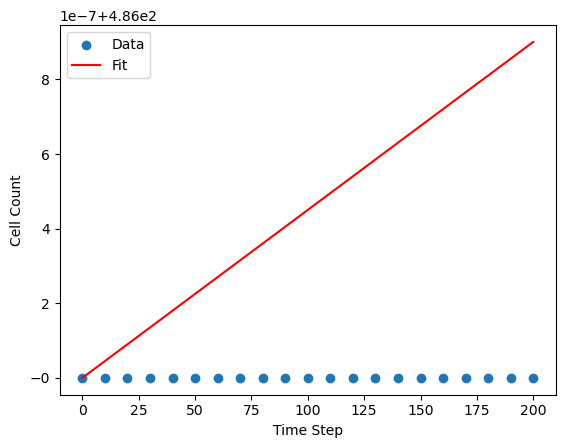

In [6]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

N0 = data["phase"][0]

# Exponential growth model
def exp_growth_model(t, r):
    return N0 * np.exp(r * t)

# Fit the model to the data
popt, pcov = curve_fit(exp_growth_model, data.index, data['phase'], p0=[0.01])

# Use the optimized parameters to calculate the fitted values
fitted_values = exp_growth_model(data.index, *popt)

# Calculate R^2 using the r2_score function from sklearn.metrics
R_squared = r2_score(data['phase'], fitted_values)

# Extract the fitted parameter (only r in this case)
r_fitted = popt[0]

# Calculate the average division time based on the fitted growth rate
average_division_time = np.log(2) / r_fitted

print(f"Known initial number of cells (N0): {N0}")
print(f"Estimated growth rate (r): {r_fitted:.4g} per time unit (R2={R_squared:.3f})")
# print(f"Average Division Time (cell cycle duration): {average_division_time} time units")
print(f"Average cell cycle duration: {(average_division_time/60):.2f} hours")
# print(R_squared)
# Plot the data and the fit
plt.scatter(data.index, data['phase'], label='Data')
plt.plot(data.index, exp_growth_model(data.index, r_fitted), label='Fit', color='red')
plt.xlabel('Time Step')
plt.ylabel('Cell Count')
plt.legend()
plt.show()

This part was used to find the proper value for our scaling parameter. By entering desired duration of our cell cycle, we can compute the adjusted scaling value in order to obtain it. 

In [7]:
# Known values
desired_cell_cycle_duration_hours = 24  # hours
observed_average_cell_cycle_duration_hours = average_division_time/60 # hours
current_scaling_factor = 40

# Compute the correction factor
correction_factor = desired_cell_cycle_duration_hours / observed_average_cell_cycle_duration_hours

# Apply the correction factor to the current scaling factor
corrected_scaling_factor = current_scaling_factor * correction_factor

print(f"Correction Factor: {correction_factor}")
print(f"Corrected Scaling Factor: {corrected_scaling_factor}")

Correction Factor: 1.9245900201199895e-08
Corrected Scaling Factor: 7.698360080479958e-07


## Analysis of phases durations

Once the data is loaded, we can look at the distribution of phases duration, and their average value.

First, we need to compute the average durations of each phase. Since what we obtain at each time point is the duration of the phase at that time point, we only need to keep the last timepoint for each phase. 

In [8]:
def filter_duration(full_data, phase, ID):
    df = full_data[(full_data.phase == phase) & (full_data.ID == ID)]
    df2 = df.copy()

    for i in range(1, len(df["duration"])):
        index_prev = df["duration"].index[i - 1]
        index = df["duration"].index[i]
        if df["duration"][index] > df["duration"][index_prev]:
            df2.drop([index_prev], inplace=True)
    return df2

In [9]:
IDs = full_data.ID.drop_duplicates()
phases = ["G0G1_phase", "S_phase", "G2M_phase"]

filtered_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])

for name in tqdm(IDs):
    for phase in phases:
        a = filter_duration(full_data, phase, name)
        filtered_data = pd.concat([filtered_data, a], ignore_index=True)

  0%|          | 0/486 [00:00<?, ?it/s]

We then plot the distribution of the duration of each phase

/tmp/ipykernel_127996/601493109.py:2: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sb.displot(filtered_data, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
/tmp/ipykernel_127996/601493109.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sb.displot(filtered_data, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)


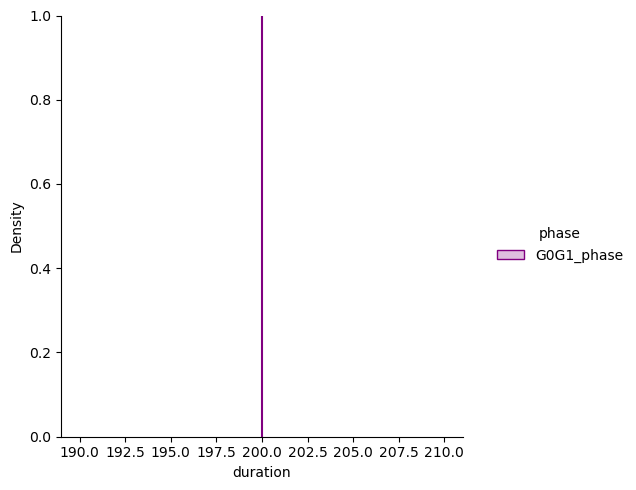

In [10]:
palette = ['purple', 'dodgerblue', 'orange']
sb.displot(filtered_data, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

We can see that some cell cycles phases can get very long, most likely due to incomplete cycles in the Sizek model. However, they are very rare cases, and most of the distribution has coherent values. We can filter out durations above 1000 minutes to have a better look at the distributions.

In [11]:
filtered_data_duration = filtered_data[filtered_data['duration'].abs() < 1000]

/tmp/ipykernel_127996/1160040058.py:2: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sb.displot(filtered_data_duration, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
/tmp/ipykernel_127996/1160040058.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sb.displot(filtered_data_duration, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)


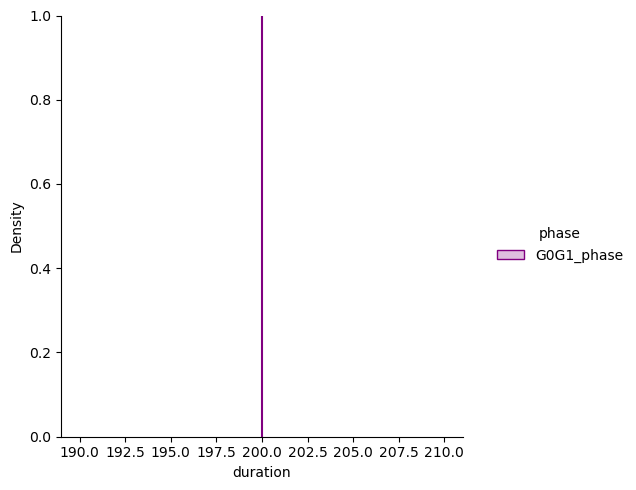

In [12]:
palette = ['purple', 'dodgerblue', 'orange']
sb.displot(filtered_data_duration, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

Here we can see better the distributions. Average values look similar to what is in the flow cytometry model of PhysiCell : 5 hours for G0G1 and for G2M, 8 hours for S phase. 

<Axes: xlabel='time_step', ylabel='counts'>

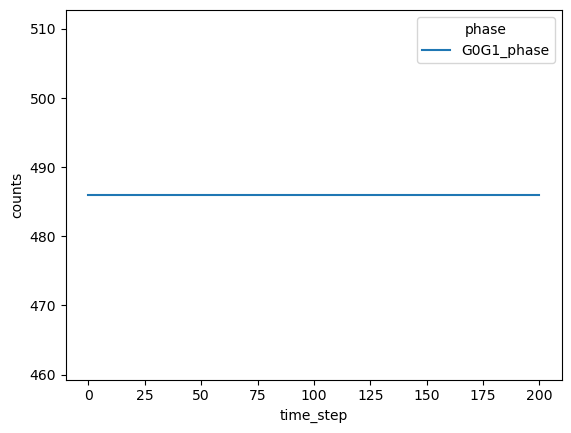

In [13]:
df2 = full_data.groupby(['time_step','phase'])['phase'].count().reset_index(name='counts')

sb.lineplot(data=df2, x="time_step", y="counts", hue="phase")

However, when looking at the growth curves for each phase of the cell cycle, we can see that while S phase is clearly the longest, G0G1 seems to be longer than G2M.

## PLK1 Knock-Out Analysis

We then look at the effect of a PLK1 knock out on our model. The simulation results analysed here can be produced by running the model with the XML settings **PhysiCell_settings_plk1_knockout_notebook.xml**. 
Once simulated, we can load the data in the same way as with the wild type model.

In [14]:
path = "../../../../output_plk1_knockout"
xml_files = []
for folder, cose, files in os.walk(path):
    for name in files:
        if name.endswith(".xml") & name.startswith("output"):
            xml_files.append(name)
            
xml_files.sort()

In [15]:
full_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])    

for file in tqdm(xml_files):
    
    mcds = pc.pyMCDS(file, path, custom_type={'sample': np.float64}, verbose=False)
    
    time = mcds.data["metadata"]["current_time"]
    
    for i in mcds.data["discrete_cells"]["data"]["ID"]:
        ID = i
        index = np.where(mcds.data["discrete_cells"]["data"]["ID"] == ID)
        phase = phase_dict[int(mcds.data["discrete_cells"]["data"]["current_phase"][index][0])]
        phase_duration = int(mcds.data["discrete_cells"]["data"]["elapsed_time_in_phase"][index][0])
        new_entry = pd.Series({"time_step":time, "ID":ID,
                     "phase":phase, "duration":phase_duration})
        full_data = pd.concat([full_data, new_entry.to_frame().T], ignore_index=True)

  0%|          | 0/241 [00:00<?, ?it/s]

In [16]:
IDs = full_data.ID.drop_duplicates()
phases = ["G0G1_phase", "S_phase", "G2M_phase"]

filtered_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])

for name in IDs:
    for phase in phases:
        a = filter_duration(full_data, phase, name)
        filtered_data = pd.concat([filtered_data, a], ignore_index=True)

And then look at the distribution of cell cycle phase durations observed during our simulation. 

AVERAGE DURATION OF EACH CELL CYCLE PHASE


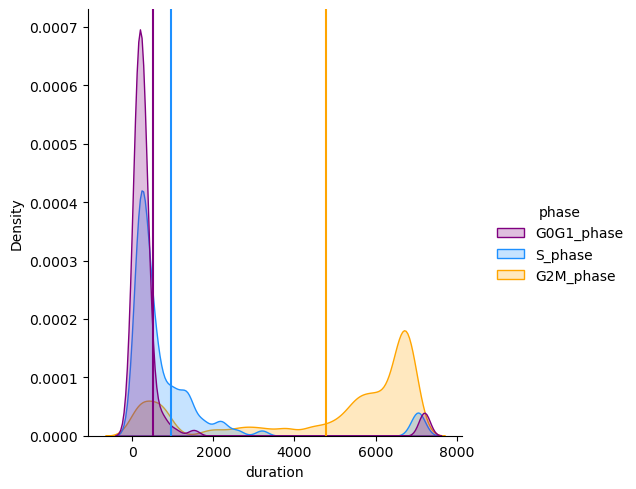

In [17]:
palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

We can see that there is a big accumulation of cells taking close to the whole duration of the simulation is G2M phase, meaning the cell cycle is blocked in G2M. 

<Axes: xlabel='time_step', ylabel='counts'>

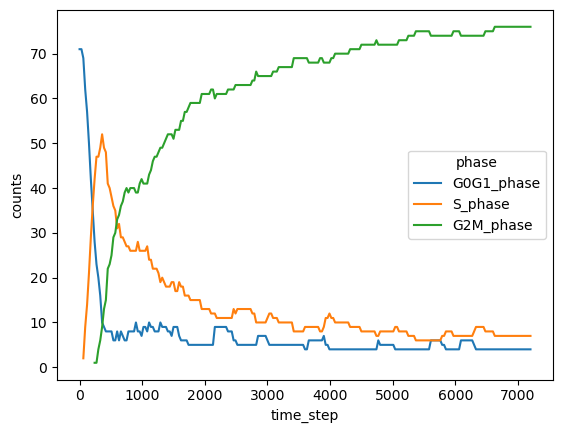

In [18]:
df2 = full_data.groupby(['time_step','phase'])['phase'].count().reset_index(name='counts')

sb.lineplot(data=df2, x="time_step", y="counts", hue="phase")

When looking at the growth curves by cell phase, we see that the total size of the population reaches a plateau, which is only composed of cells in G2M phase. Interestingly, it seems that no cells is activating apoptosis. 

## FOXO3 KNOCK-OUT ANALYSIS

We then look at another mutant : FoxO3 inhibition. Again, the simulation results analysed here can be produced by running the model with the XML settings **PhysiCell_settings_foxo3_knockout_notebook.xml**. 
Once simulated, we can load the data in the same way as with the wild type model.

In [19]:
path = "../../../../output_foxo3_knockout/"
xml_files = []
for folder, cose, files in os.walk(path):
    for name in files:
        if name.endswith(".xml") & name.startswith("output"):
            xml_files.append(name)
            
xml_files.sort()

In [20]:
full_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])    

for file in tqdm(xml_files):
    
    mcds = pc.pyMCDS(file, path, custom_type={'sample': np.float64}, verbose=False)
    
    time = mcds.data["metadata"]["current_time"]
    
    for i in mcds.data["discrete_cells"]["data"]["ID"]:
        ID = i
        index = np.where(mcds.data["discrete_cells"]["data"]["ID"] == ID)
        phase = phase_dict[int(mcds.data["discrete_cells"]["data"]["current_phase"][index][0])]
        phase_duration = int(mcds.data["discrete_cells"]["data"]["elapsed_time_in_phase"][index][0])
        new_entry = pd.Series({"time_step":time, "ID":ID,
                     "phase":phase, "duration":phase_duration})
        full_data = pd.concat([full_data, new_entry.to_frame().T], ignore_index=True)

  0%|          | 0/241 [00:00<?, ?it/s]

In [21]:
IDs = full_data.ID.drop_duplicates()
phases = ["G0G1_phase", "S_phase", "G2M_phase"]

filtered_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])

for name in tqdm(IDs):
    for phase in phases:
        a = filter_duration(full_data, phase, name)
        filtered_data = pd.concat([filtered_data, a], ignore_index=True)

  0%|          | 0/188 [00:00<?, ?it/s]

After loading the data, we can again look at the distribution of cell cycle phases. 

AVERAGE DURATION OF EACH CELL CYCLE PHASE


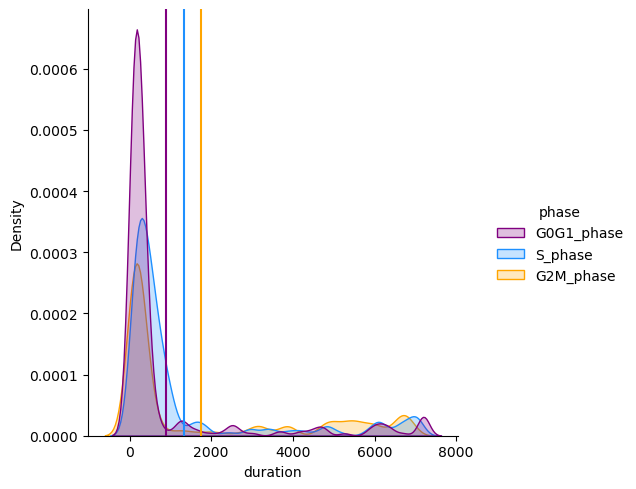

In [22]:
palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

Here we see that cells have a larger tail in all phases : cycle is active, but is slowed down in all phases.

<Axes: xlabel='time_step', ylabel='counts'>

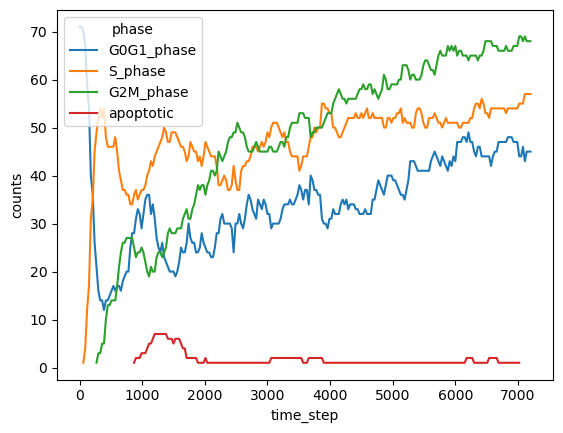

In [23]:
df2 = full_data.groupby(['time_step','phase'])['phase'].count().reset_index(name='counts')

sb.lineplot(data=df2, x="time_step", y="counts", hue="phase")

Here we get a better idea of the behavior of this mutant. After a first normal cell cycle, we see a large amount of cell death, followed by a slow growth, corresponding to the long cell cycle phases observed above. 

## p110_H KNOCK-IN ANALYSIS

Finally, we look at one more mutant : p110++. Again, the simulation results analysed here can be produced by running the model with the XML settings **PhysiCell_settings_p110_kockin_notebook.xml**. 
Once simulated, we can load the data in the same way as with the wild type model.

In [24]:
path = "../../../../output_p110_knockin"

xml_files = []
for folder, cose, files in os.walk(path):
    for name in files:
        if name.endswith(".xml") & name.startswith("output"):
            xml_files.append(name)
            
xml_files.sort()

In [25]:
full_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])    

for file in tqdm(xml_files):
    
    mcds = pc.pyMCDS(file, path, custom_type={'sample': np.float64}, verbose=False)
    
    time = mcds.data["metadata"]["current_time"]
    
    for i in mcds.data["discrete_cells"]["data"]["ID"]:
        ID = i
        index = np.where(mcds.data["discrete_cells"]["data"]["ID"] == ID)
        phase = phase_dict[int(mcds.data["discrete_cells"]["data"]["current_phase"][index][0])]
        phase_duration = int(mcds.data["discrete_cells"]["data"]["elapsed_time_in_phase"][index][0])
        new_entry = pd.Series({"time_step":time, "ID":ID,
                     "phase":phase, "duration":phase_duration})
        full_data = pd.concat([full_data, new_entry.to_frame().T], ignore_index=True)

  0%|          | 0/161 [00:00<?, ?it/s]

In [26]:
IDs = full_data.ID.drop_duplicates()
phases = ["G0G1_phase", "S_phase", "G2M_phase"]

filtered_data = pd.DataFrame(columns=["time_step", "ID", "phase", "duration"])

for name in tqdm(IDs):
    for phase in phases:
        a = filter_duration(full_data, phase, name)
        filtered_data = pd.concat([filtered_data, a], ignore_index=True)

  0%|          | 0/1712 [00:00<?, ?it/s]

AVERAGE DURATION OF EACH CELL CYCLE PHASE


/tmp/ipykernel_127996/3774474368.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
/tmp/ipykernel_127996/3774474368.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
/tmp/ipykernel_127996/3774474368.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),


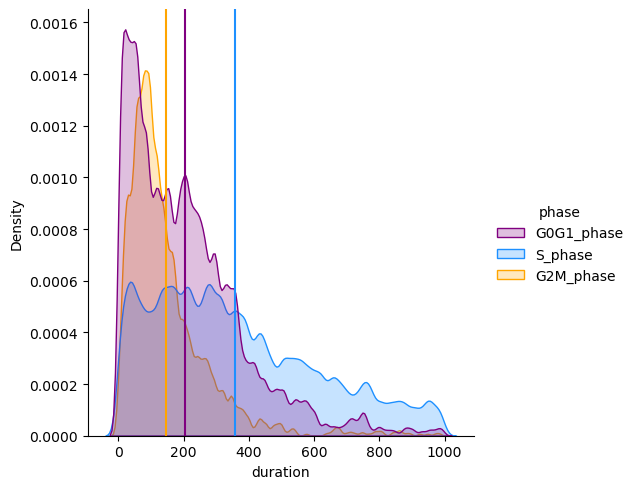

In [27]:
filtered_data_duration = filtered_data[filtered_data['duration'].abs() < 1000]

palette = ['purple', 'dodgerblue', 'orange']
print("AVERAGE DURATION OF EACH CELL CYCLE PHASE")
sb.displot(filtered_data_duration, x="duration", kind="kde", hue='phase', fill=True, bw_adjust=.25, palette=palette)
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G2M_phase")]["duration"].mean(),
            color='orange')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "G0G1_phase")]["duration"].mean(),
            color='purple')
plt.axvline(x=filtered_data_duration[(filtered_data.phase == "S_phase")]["duration"].mean(),
            color='dodgerblue')

#change color into red blue yellow

Here we don't see much difference in the phasers durations, aside from a shorted G2M phase. 

<Axes: xlabel='time_step', ylabel='counts'>

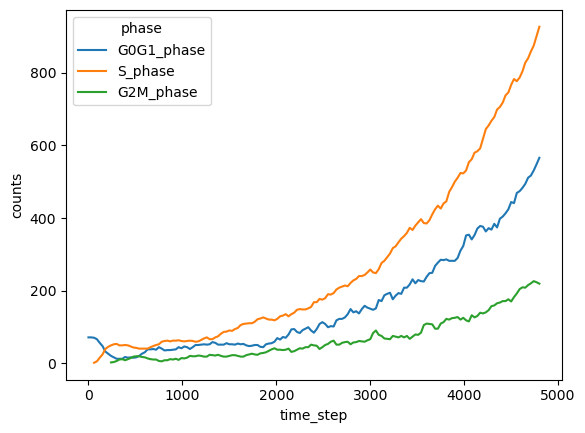

In [28]:
df2 = full_data.groupby(['time_step','phase'])['phase'].count().reset_index(name='counts')

sb.lineplot(data=df2, x="time_step", y="counts", hue="phase")

And again, by looking at the growth curves, we obtain a very similar distribution of phase durations as for the wild type. The big difference is not in the phase duration : it is in the complete inactivation of apoptosis. 